In [1]:
import os
import sys
import glob
import torch
import numpy as np
import polars as pl
import pandas as pd
import lightning as L
import matplotlib.pyplot as plt
import tables


from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from lightning.pytorch.callbacks import ModelCheckpoint, ProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

np.random.seed(seed=1)
L.seed_everything(seed=1, workers=True)


Seed set to 1


1

In [2]:
import sys
print(sys.executable)


/cvmfs/sft.cern.ch/lcg/views/LCG_107_cuda/x86_64-el9-gcc11-opt/bin/python3


In [3]:
import h5py

with h5py.File("ntuple_merged_3.h5", "r") as f:
    for key in f.keys():
        print(f"Dataset: {key}, Shape: {f[key].shape}, Type: {f[key].dtype}") 
 #   print(f['event'][:10])
    print(f['nElectron'][:5])
    print(f['nMuon'][:5])
    


Dataset: A_Dr_Z, Shape: (50000,), Type: float32
Dataset: A_Zmass, Shape: (50000,), Type: float32
Dataset: B_Dr_Z, Shape: (50000,), Type: float32
Dataset: B_Zmass, Shape: (50000,), Type: float32
Dataset: C_Dr_Z, Shape: (50000,), Type: float32
Dataset: C_Zmass, Shape: (50000,), Type: float32
Dataset: D_Dr_Z, Shape: (50000,), Type: float32
Dataset: D_Zmass, Shape: (50000,), Type: float32
Dataset: Dataset_ID, Shape: (50000,), Type: float32
Dataset: MET_pt, Shape: (50000,), Type: float32
Dataset: event, Shape: (50000,), Type: float32
Dataset: nElectron, Shape: (50000,), Type: float32
Dataset: nMuon, Shape: (50000,), Type: float32
[0. 4. 0. 0. 2.]
[4. 0. 3. 3. 3.]


Unique Dataset_ID values: [1 2 3 4]
Counts: [17814 31863   197   126]


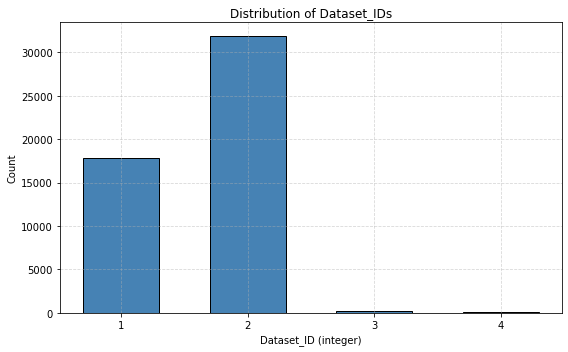

In [4]:
import h5py
 
with h5py.File("ntuple_merged_3.h5", "r") as f:
    dataset_ids = f['Dataset_ID'][:]

# Get unique integer values and their counts
unique_ids, counts = np.unique(dataset_ids.astype(int), return_counts=True)
 
# Print for inspection
print("Unique Dataset_ID values:", unique_ids)
print("Counts:", counts)
 
# Plot
plt.figure(figsize=(8, 5))
plt.bar(unique_ids, counts, width=0.6, color='steelblue', edgecolor='black')
plt.xlabel('Dataset_ID (integer)')
plt.ylabel('Count')
plt.title('Distribution of Dataset_IDs')
plt.xticks(unique_ids)  # Show each unique ID
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Define the list of variables from the h5 file to use as features, spectator and labels

In [5]:
features = [
    "A_Dr_Z",
    "B_Dr_Z",
    "C_Dr_Z",
    "D_Dr_Z",
    "MET_pt",
]

# spectators to define mass/pT window
# spectators = ['fj_sdmass',
#               'fj_pt']

#
labels = ['Dataset_ID']

nfeatures = len(features)
# nspectators = len(spectators)
# nlabels = len(labels)

In [6]:
def get_features_labels(file_name):
   
    h5file = tables.open_file(file_name, 'r')

    nevents = getattr(h5file.root, features[0]).shape[0]  # Tomar el número de eventos del primer feature

    feature_array = np.zeros((nevents, nfeatures))  # Cada feature tiene 10 valores por evento
    label_array = np.zeros((nevents, 2))
 
    # load feature arrays
    for (i, feat) in enumerate(features):
        feature_array[:,i] = getattr(h5file.root,feat)[:]

    # Define which Dataset_ID values correspond to background (QCD)
    bkg_ids = {1,2}  # Modify with actual background IDs

    # Load labels arrays
    for (i, label) in enumerate(labels):
        dataset_id_array = getattr(h5file.root, label)[:]  # Load Dataset_ID from HDF5
        label_array[:, 0] = np.isin(dataset_id_array, list(bkg_ids)).astype(int)  # Background
        label_array[:, 1] = 1 - label_array[:, 0]  # Signal
    
    h5file.close()
    return feature_array, label_array

In [7]:
# load training file
feature_array, label_array = get_features_labels('ntuple_merged_3.h5')
print(feature_array.shape)
print(label_array.shape)

(50000, 5)
(50000, 2)


### Histogramas 

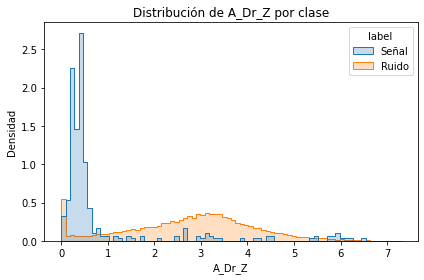

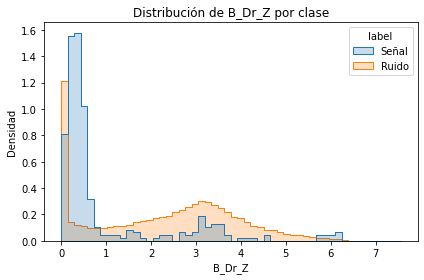

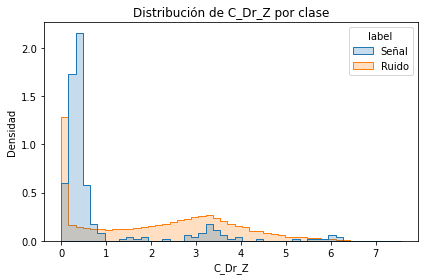

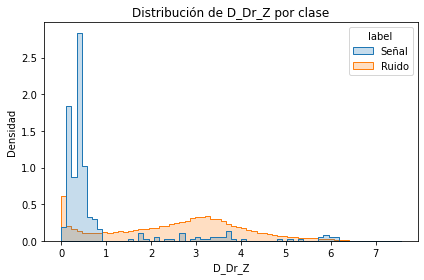

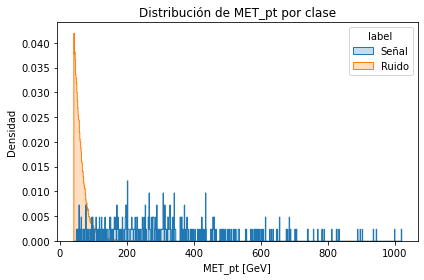

In [8]:
# — Sección: Histogramas por clase —
import seaborn as sns

# convierte arrays en DataFrame para facilitar plotting
df = pd.DataFrame(feature_array, columns=features)
df['label'] = np.where(label_array[:,1]==1, 'Señal','Ruido')

# Mapa de unidades para cada feature
unit_map = {
    "A_Dr_Z": "",            # delta-R no tiene unidades
    "A_Zmass": "GeV",
    "B_Dr_Z": "",
    "B_Zmass": "GeV",
    "C_Dr_Z": "",
    "C_Zmass": "GeV",
    "D_Dr_Z": "",
    "D_Zmass": "GeV",
    "MET_pt": "GeV",
    "nElectron": "",  # cuenta de electrones
    "nMuon": ""       # cuenta de muones
}

for feat in features:
    # construye la etiqueta del eje X incluyendo unidad si existe
    unidad = unit_map.get(feat, "")
    xlabel = feat + (f" [{unidad}]" if unidad else "")
    #guardar nombres
    short = feat.lower().replace('_', '')
    fname = f"figs/{short}.pdf"
    
    plt.figure(figsize=(6,4))
    sns.histplot(
        data=df,
        x=feat,
        hue='label',
        stat='density',
        element='step',
        common_norm=False
    )
#    plt.xlim(0, 6) 
    plt.title(f'Distribución de {feat} por clase')
    plt.xlabel(xlabel)
    plt.ylabel('Densidad')
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

### Load the data (numpy.array) into a DatasetLoad (Tensor)

### Mapa de correlaciones

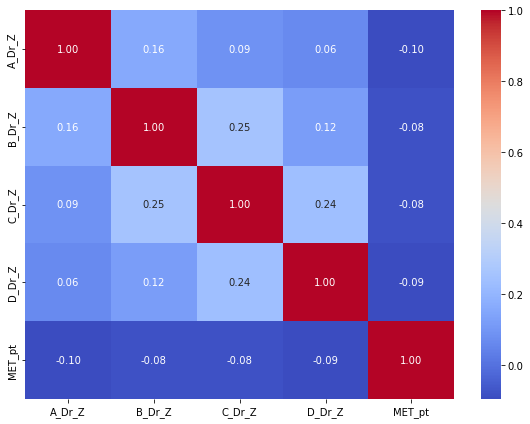

In [9]:
# — Sección: Correlación entre features —
plt.figure(figsize=(8,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
#plt.title('Mapa de correlaciones del features')
plt.tight_layout()
plt.savefig("figs/corrmap.pdf", bbox_inches="tight")
plt.show()

In [10]:
# Divide train and validation+test
X_train, X_temp, _, y_temp  = train_test_split(feature_array, label_array, test_size=0.2, random_state=42, shuffle=True)

# Divide validation+test in validation and test
X_valid, X_test, _, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
class SensorDataset(Dataset):

    def __init__(self, dataset: np.array):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return torch.FloatTensor(self.dataset[index])

## Autoencoder
#### AE: Pytorch Lightning Model Implementation
Implementation of a plain Autoencoder

In [12]:
ae_train_ds = SensorDataset(X_train)
ae_valid_ds = SensorDataset(X_valid)
ae_test_ds = SensorDataset(X_test)

In [13]:
ae_train_ds[3]

tensor([ 1.1147,  3.1036,  0.5620,  0.5620, 54.6952])

In [14]:
class Autoencoder(L.LightningModule):

    def __init__(self, in_dim):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.BatchNorm1d(64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 16),
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.SELU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.SELU(),
            nn.Linear(64, in_dim)
        )

        self.training_losses = []
        self.validation_losses = []

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def training_step(self, batch, batch_idx):
        x    = batch
        x_hat = self(x)
        loss  = F.smooth_l1_loss(x_hat, x)

        # log de pérdida
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.training_losses.append(self.trainer.callback_metrics['train_loss'].item())

    def validation_step(self, batch, batch_idx):
        input = batch
        output = self.forward(input)
        loss = F.smooth_l1_loss(output, input)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.validation_losses.append(self.trainer.callback_metrics['val_loss'].item())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input = batch
        output = self.forward(input)
        return output

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-4, weight_decay=1e-5)

#### PyTorch Progress Bar Implementation

In [15]:
class SimpleProgressBar(ProgressBar):
    def __init__(self):
        super().__init__()
        self.bar = None
        self.enabled = True

    def on_train_epoch_start(self, trainer, pl_module):
        if self.enabled:
            self.bar = tqdm(total=self.total_train_batches,
                            desc=f"Epoch {trainer.current_epoch+1}",
                            position=0,
                            leave=True)
            self.running_loss = 0.0

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if self.bar:
            self.running_loss += outputs['loss'].item()
            self.bar.update(1)
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}')
            # self.bar.set_postfix(self.get_metrics(trainer, pl_module))

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        if self.bar:
            val_loss = trainer.logged_metrics['val_loss'].item()
            loss = self.running_loss / self.total_train_batches
            self.bar.set_postfix(loss=f'{loss:.4f}', val_loss=f'{val_loss:.4f}')
            self.bar.close()
            self.bar = None

    def disable(self):
        self.bar = None
        self.enabled = False

In [16]:
in_dim = ae_train_ds.dataset.shape[1]
model = Autoencoder(in_dim)

batch_size = 32
ae_tdl, ae_vdl = DataLoader(ae_train_ds, batch_size=batch_size, num_workers=4), DataLoader(ae_valid_ds, batch_size=batch_size, num_workers=4)

In [17]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

# Mantén tus callbacks actuales…
es         = EarlyStopping(monitor="val_loss", mode="min", min_delta=1e-4, patience=5)
cp         = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")
pb         = SimpleProgressBar()
lr_monitor = LearningRateMonitor(logging_interval='step')

#model.training_losses.clear()
#model.validation_losses.clear()

#  Instancia el Trainer incluyendo el nuevo callback y el logger
trainer = L.Trainer(
    callbacks=[pb, es, cp, lr_monitor],
    max_epochs=1_000,
    enable_checkpointing=True,
    accelerator="auto"
)

# 4) Entrena 
trainer.fit(model, train_dataloaders=ae_tdl, val_dataloaders=ae_vdl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-05-06 00:36:05.557132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 00:36:05.579216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746484565.605386     353 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746484565.613507     353 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 00:36:05.645658:

### Monitorización de entrenamiento

### Loss curve

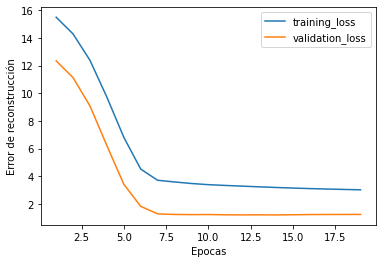

In [18]:
num_iter = len(model.training_losses)
x = np.linspace(1, num_iter, num_iter)
fig = plt.figure()
plt.plot(x, model.training_losses, label="training_loss")
plt.plot(x, model.validation_losses[1:], label="validation_loss")
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Error de reconstrucción')
plt.savefig("figs/losscurv.pdf")
plt.show()

In [19]:
print(cp.best_model_path)
print(cp.best_model_score)
model = Autoencoder.load_from_checkpoint(cp.best_model_path)

/eos/home-i03/m/mterraza/SWAN_projects/lightning_logs/version_14/checkpoints/epoch=13-step=17500.ckpt
tensor(1.2043, device='cuda:0')


### AE Result Visualization

In [20]:
test_ds = SensorDataset(X_test)
tdl = DataLoader(test_ds, batch_size=batch_size, num_workers=3)
pred = trainer.predict(model, tdl)

try:
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)
except ValueError:  # caused by VAE
    pred = [tup[0] for tup in pred]
    reco = np.mean((np.vstack(pred) - X_test) ** 2, axis=1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Histograma de reconstruction error 

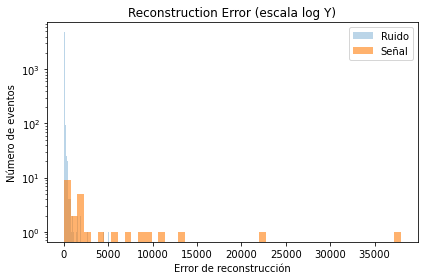

In [21]:
# transforma cada fila [0,1] ó [1,0] en un único entero 0=ruido, 1=señal
labels_test = y_test.argmax(axis=1)

# índices de ruido y señal
ruido_idx = y_test[:,0] == 1
senal_idx = y_test[:,1] == 1

signal_errors = reco[senal_idx]

plt.figure(figsize=(6,4))
plt.hist(reco[ruido_idx], bins=50, alpha=0.3, label='Ruido')
plt.hist(signal_errors,     bins=50, alpha=0.6, label='Señal')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Número de eventos')
plt.title('Reconstruction Error (escala log Y)')
plt.legend()
plt.yscale('log')        # ← aquí
plt.tight_layout()
plt.savefig("figs/REH.pdf")
plt.show()


### Curva ROC

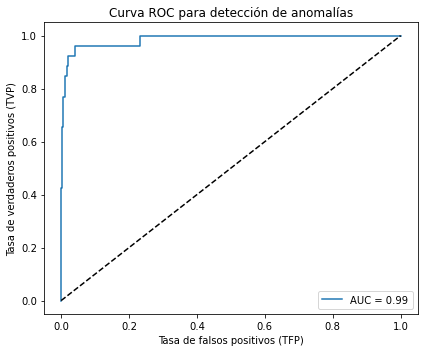

In [22]:
from sklearn.metrics import roc_curve, auc

# 1) Extraer las etiquetas verdaderas: 1=señal, 0=ruido
y_true = y_test[:, 1]

# 2) Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_true, reco)
roc_auc = auc(fpr, tpr)

# 3) Dibujar la curva
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Tasa de falsos positivos (TFP)')
plt.ylabel('Tasa de verdaderos positivos (TVP)')
plt.title('Curva ROC para detección de anomalías')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("figs/rocurv.pdf")
plt.show()

#fpr, tpr, _ = roc_curve(labels_test, reco)

 ### PCA del espacio latente

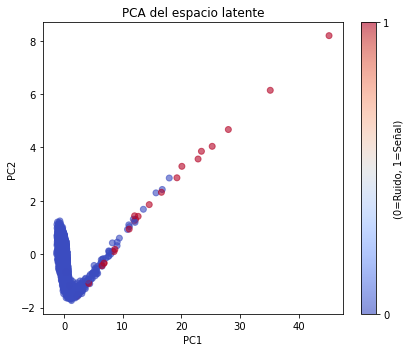

In [23]:
from sklearn.decomposition import PCA

# 1) Obtén los latentes como antes
X_test_tensor = torch.FloatTensor(X_test)
latents = model.encoder(X_test_tensor).detach().numpy()

# 2) Proyección PCA a 2D
pca  = PCA(n_components=2)
proj = pca.fit_transform(latents)

# 3) Convierte y_test (n×2) a etiquetas escalares (n,)
labels_test = y_test.argmax(axis=1)   # 0=ruido, 1=señal

# 4) Ahora sí puedes hacer el scatter
plt.figure(figsize=(6,5))
plt.scatter(
    proj[:, 0],
    proj[:, 1],
    c=labels_test,       # vector 1-D de tamaño n_samples
    alpha=0.6,
    cmap='coolwarm'
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA del espacio latente')
plt.colorbar(ticks=[0,1], label=('(0=Ruido, 1=Señal)'))
plt.tight_layout()
plt.savefig("figs/PCA.pdf")
plt.show()

### SNE del espacio latente

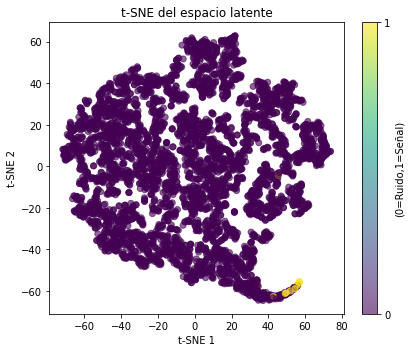

In [24]:
# — Sección: t-SNE del espacio latente —
from sklearn.manifold import TSNE

# 1) Calcula la incrustación t-SNE sobre los latentes ya obtenidos
tsne  = TSNE(n_components=2, random_state=42)
embed = tsne.fit_transform(latents)

# 2) Convierte y_test (n×2) a etiquetas escalares (n,)
labels_test = y_test.argmax(axis=1)   # 0=ruido, 1=señal

# 3) Grafica con c=labels_test
plt.figure(figsize=(6,5))
plt.scatter(
    embed[:, 0],
    embed[:, 1],
    c=labels_test,
    alpha=0.6,
    cmap='viridis'
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE del espacio latente')
plt.colorbar(ticks=[0,1], label='(0=Ruido,1=Señal)')
plt.tight_layout()
plt.savefig("figs/SNE.pdf")
plt.show()


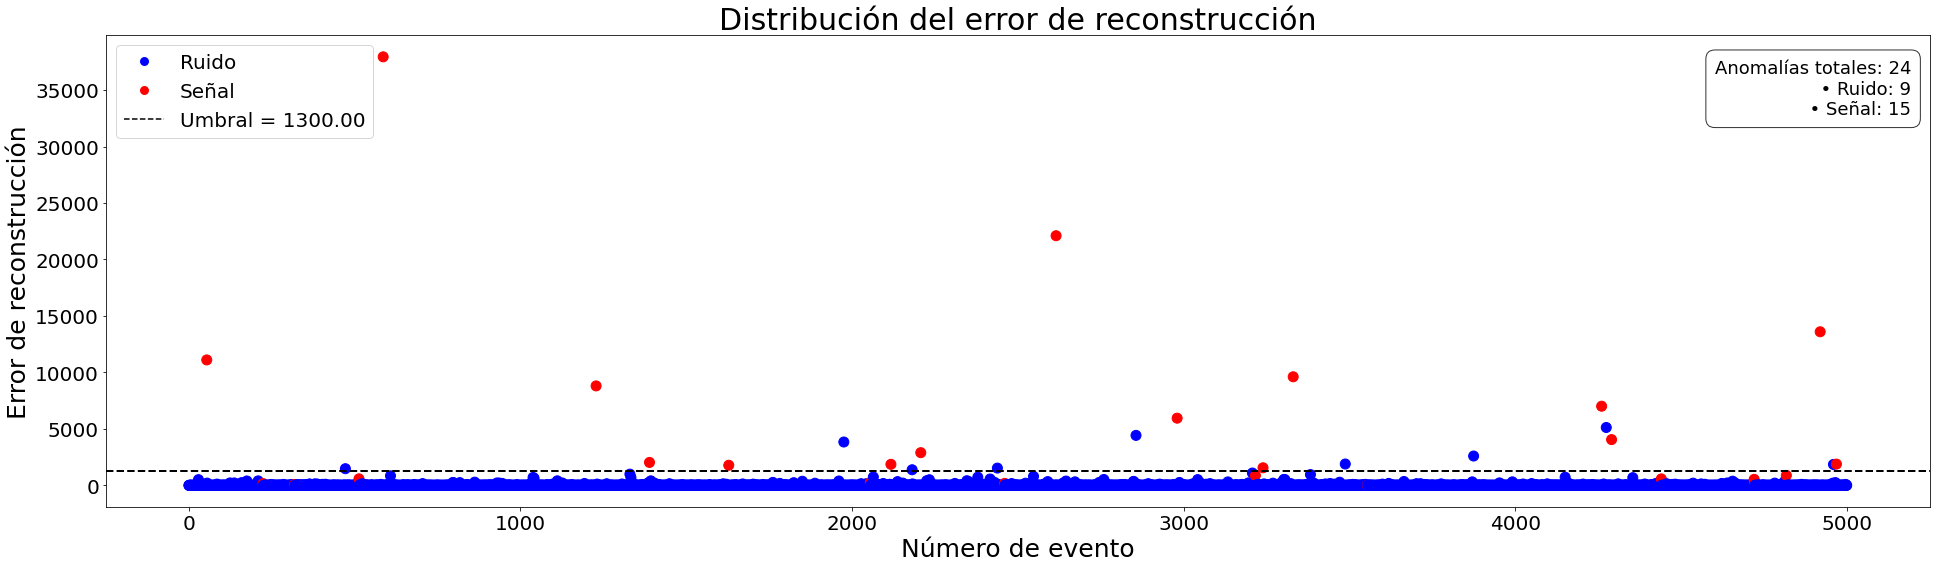

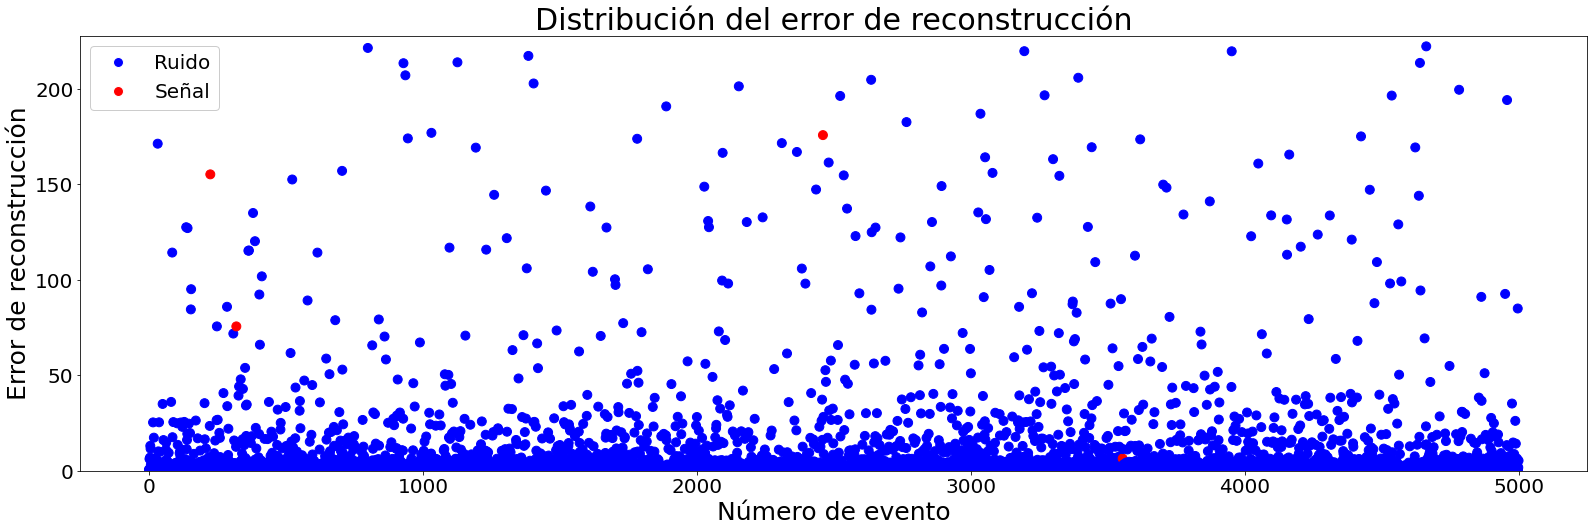

In [25]:
# Definir el umbral 
#threshold = np.median(reco) * 5 

# Identificar los puntos anómalos
#test_label_colors = np.where(reco > threshold, 'red', 'blue')  


# --- Paso 1: definir el umbral ---
threshold = 1300


ruido_idx = y_test[:,0] == 1
senal_idx = y_test[:,1] == 1

anom_mask = reco > threshold


num_total_anom = np.sum(anom_mask)
num_ruido_anom = np.sum(anom_mask & ruido_idx)
num_senal_anom = np.sum(anom_mask & senal_idx)


label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in y_test[:, 1]])

legend_elements = [
    Line2D([0],[0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Ruido'),
    Line2D([0],[0], marker='o', color='w', markerfacecolor='red',  markersize=10, label='Señal'),
    Line2D([0],[0], linestyle='--', color='black', label=f'Umbral = {threshold:.2f}')
]


plt.figure(figsize=(27,8))
plt.scatter(
    np.arange(len(reco)), reco,
    c=test_label_colors,
    s=100, alpha=1
)
plt.axhline(threshold, color='black', linestyle='--', linewidth=2)


txt = (
    f"Anomalías totales: {num_total_anom}\n"
    f"  • Ruido: {num_ruido_anom}\n"
    f"  • Señal: {num_senal_anom}"
)
plt.text(
    0.99, 0.95, txt,
    transform=plt.gca().transAxes,
    ha='right', va='top',
    fontsize=18,
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8)
)

plt.xlabel('Número de evento', fontsize=25)
plt.ylabel('Error de reconstrucción', fontsize=25)
plt.title('Distribución del error de reconstrucción', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(handles=legend_elements, fontsize=20, title='', loc='upper left')
plt.tight_layout()
plt.savefig("figs/scat.pdf")
plt.show()


label_color_mapping = {0: 'blue', 1: 'red'}
test_label_colors = np.array([label_color_mapping[label] for label in y_test[:, 1]])

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                   for label, color in label_color_mapping.items()]


# Zoomed
plt.figure(figsize=(27, 8))
scatter_zoomed = plt.scatter(range(X_test.shape[0]), reco, label='Error de reconstrucción', c=test_label_colors, s=80, alpha=1)
plt.ylim(0, np.median(reco) * 100)
plt.xlabel('Número de evento', fontsize=25)
plt.ylabel('Error de reconstrucción', fontsize=25)
plt.title('Distribución del error de reconstrucción', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.legend(handles=legend_elements, title='', labels=['Ruido', 'Señal'],fontsize=20, loc='upper left', framealpha=1)
plt.savefig("figs/scatzoom.pdf")
plt.show()